c:\Users\yuncs\anaconda3\envs\yolov7\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


using GPU : True
CUDA:0 (NVIDIA TITAN RTX, 24575.5625MB)

(1051, 224, 224, 3) (1051,)
(1051,)
840 105 106
105 14 14
CNN_deep(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (Maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    

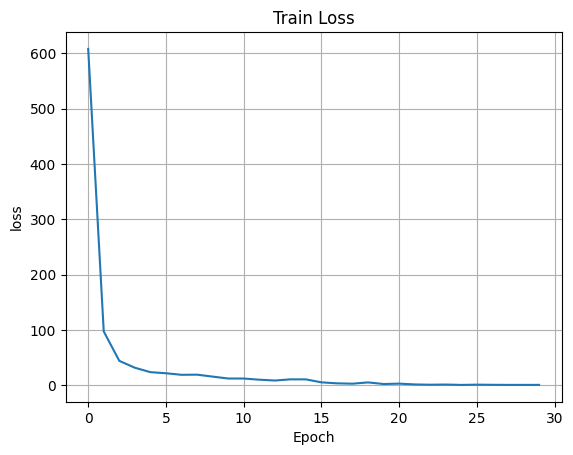

In [1]:
# CNN test

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
#from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch import optim

#"""
BATCH_SIZE = 8
DEVICE = "0" # 'cpu' or '0' or '0,1,2,3'

def select_device(DEVICE, BATCH_SIZE):
    flag_device = DEVICE.lower() == "cpu"
    if flag_device:
        os.environ['CUDA_VISIBLE_DEVICE'] = "-1"
    else:
        os.environ['CUDA_VISIBLE_DEVICE'] = DEVICE
        assert torch.cuda.is_available(), f"CUDA unavailable, invaild device {DEVICE} requested"
    print("using GPU :", not flag_device and torch.cuda.is_available())

    flag_cuda = not flag_device and torch.cuda.is_available()
    if flag_cuda:
        num_cuda = torch.cuda.device_count()
        if num_cuda > 1 and BATCH_SIZE:
            assert BATCH_SIZE % num_cuda == 0, f"Batch size {BATCH_SIZE} not multiple of GPU count {num_cuda}"
        for i, val in enumerate(DEVICE.split(",")):
            p = torch.cuda.get_device_properties(i)
            print(f"CUDA:{val} ({p.name}, {p.total_memory / 1024 ** 2}MB)\n")
    return torch.device('cuda' if flag_cuda else "cpu")

device = select_device(DEVICE, BATCH_SIZE)
#"""

img_formats = ['.bmp', '.jpg', '.jpeg', '.png', '.tif', '.tiff', '.dng', '.webp', '.mpo']

w, h = 224, 224
label_list = []
X = []
Y = []
for (path, dir, files) in os.walk('C:\\Users\\yuncs\\Desktop\\caltech20\\'):
    if path.split('\\')[-1] not in label_list: label_list.append(path.split('\\')[-1])
    for i in files:
        ext = os.path.splitext(i)[-1]
        if ext in img_formats:
            filename = path + '\\' + i
            resize_img = cv2.resize(cv2.imread(filename), (w, h))
            X.append(resize_img)
            Y.append(label_list.index(path.split('\\')[-1])-1)

#print(label_list)
X = np.array(X)
Y = np.array(Y, dtype=np.int64) # if using CrossEntropyLoss then datatype Long
print(X.shape, Y.shape)
#plt.imshow(X[1050])
#print(Y[1050])

# change tensor but it's not good mathod
#X = torch.tensor(X, dtype=torch.float32)
#Y = torch.tensor(Y, dtype=torch.float32)
#print(X.shape, Y.shape)
#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
#print(X_train.shape, X_test.shape)

# new change tensor
class Custom_Dataset(torch.utils.data.Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        x = self.data[idx]
        if self.transform is not None:
            x = self.transform(x)
        y = self.label[idx]
        return x, y

transform_train = transforms.Compose([
    transforms.ToTensor()
])

custom_DS = Custom_Dataset(X, Y, transform=transform_train)
print(custom_DS.label.shape)

num_train = int(len(custom_DS)*0.8)
num_val = int(len(custom_DS)*0.1)
num_test = len(custom_DS) - num_train - num_val
train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [num_train, num_val, num_test])
print(len(train_DS), len(val_DS), len(test_DS))

x_train = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
x_val = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
x_test = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)
print(len(x_train), len(x_val), len(x_test))

#for x_batch, y_batch in x_train:
    #print(x_batch.shape)
    #print(y_batch.shape)
    #print(y_batch[0])
    #plt.imshow(x_batch[0])
    #break

# make model
class my_Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.my_layer = nn.Sequential(nn.Linear(3*224*224, 100),
                                      nn.ReLU(),
                                      nn.Sequential(*[i for _ in range(100) for i in [nn.Linear(100,100), nn.ReLU()]]),
                                      nn.Linear(100,20),
                                      nn.Sigmoid())
    
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.my_layer(x)
        return x

"""
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(nn.Conv2d(3,8,3, padding=1),
                                   nn.BatchNorm2d(8),
                                   nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Sequential(nn.Conv2d(8,16,3, padding=1),
                                   nn.BatchNorm2d(16),
                                   nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(nn.Conv2d(16,32,3, padding=1),
                                   nn.BatchNorm2d(32),
                                   nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        self.fc = nn.Linear(32*4*4, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Maxpool1(x)
        x = self.conv2(x)
        x = self.Maxpool2(x)
        x = self.conv3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc(x)
        return x
"""
#"""
class CNN_deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_block1 = nn.Sequential(nn.Conv2d(3,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU(),
                                         nn.Conv2d(32,32,3,padding=1),
                                         nn.BatchNorm2d(32),
                                         nn.ReLU())
        self.Maxpool1 = nn.MaxPool2d(2)

        self.conv_block2 = nn.Sequential(nn.Conv2d(32,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU(),
                                         nn.Conv2d(64,64,3,padding=1),
                                         nn.BatchNorm2d(64),
                                         nn.ReLU())
        self.Maxpool2 = nn.MaxPool2d(2)

        self.conv_block3 = nn.Sequential(nn.Conv2d(64,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU(),
                                         nn.Conv2d(128,128,3,padding=1),
                                         nn.BatchNorm2d(128),
                                         nn.ReLU())
        self.Maxpool3 = nn.MaxPool2d(2)
        
        self.classifier = nn.Sequential(nn.Linear(128*28*28,512),
                                        nn.Linear(512,20))
        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.Maxpool1(x)
        x = self.conv_block2(x)
        x = self.Maxpool2(x)
        x = self.conv_block3(x)
        x = self.Maxpool3(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
#"""

#model = CNN_deep() # cpu
model = CNN_deep().to(device) # gpu
print(model)
#x_batch, y_batch = next(iter(x_train))
#print(model(x_batch).shape)
#print(y_batch.dtype)

LR = 1e-3
epoch = 30
loss_func = nn.CrossEntropyLoss()
#optimer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
optimer = optim.Adam(model.parameters(), lr=LR)

def Train(model, epoch, x_trian, loss_func, optimer):
    history_loss = []
    num_train = len(x_train)

    model.train() # change train mode
    for ep in range(epoch):
        loss_ep = 0
        for x_batch, y_batch in x_train:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_h = model(x_batch) # inference
            loss = loss_func(y_h, y_batch) # loss
            optimer.zero_grad() # prevent accomulate gradient
            loss.backward() # backpropagation
            optimer.step() # parameter update
            loss_batch = loss.item() * x_batch.shape[0]
            loss_ep += loss_batch
        loss_ep = loss_ep/num_train
        history_loss += [loss_ep]
        print(f"epoch : {ep}, train_loss : {round(loss_ep, 3)}")
    
    return history_loss

loss_his = Train(model, epoch, x_train, loss_func, optimer)

plt.plot(range(0,epoch),loss_his)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title("Train Loss")
plt.grid()

# save model weight
save_path = "C:\\Users\\yuncs\\Desktop\\last2.pt"
torch.save(model.state_dict(), save_path)
#print(model.state_dict())

    


In [2]:
load_weight = CNN_deep().to(device)
load_weight.load_state_dict(torch.load(save_path, map_location=device))

def test(model, x_test):
    model.eval()
    accuracy = 0
    with torch.no_grad():
        sum_true = 0
        for x_batch, y_batch in x_test:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            y_h = model(x_batch)
            pred = y_h.argmax(dim=1)
            num_true = torch.sum(pred == y_batch).item()
            sum_true += num_true
            print(torch.sum(pred == y_batch).item())
            print(pred)
            print(y_batch)
            break
        accuracy = (sum_true/len(x_test.dataset))*100
    return accuracy

acc = test(load_weight, x_test)
print(acc)



3
tensor([ 0,  7,  1, 10, 16,  1, 18, 16], device='cuda:0')
tensor([ 8,  7, 14,  5, 16,  3, 18,  6], device='cuda:0')
2.8301886792452833


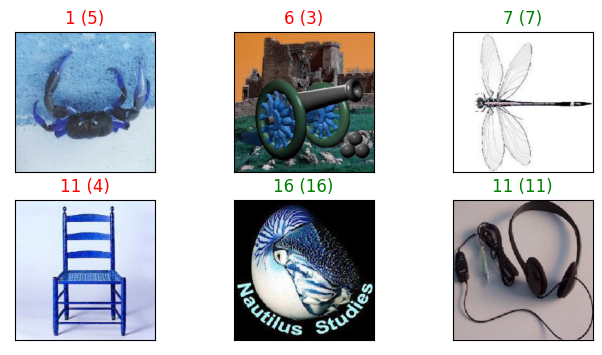

In [3]:
def Test_plot(model, x_test):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(x_test))
        x_batch = x_batch.to(device)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)

    x_batch = x_batch.to("cpu")

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap="gray")
        pred_class = pred[idx]
        true_class = y_batch[idx]
        plt.title(f"{pred_class} ({true_class})", color = "g" if pred_class==true_class else "r")

Test_plot(load_weight, x_test)


# extra study

In [4]:
# convolution layer
import torch
from torch import nn

layer = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1) # stride=1, padding=0 default
layer(torch.randn(32, 1, 5, 5)).shape

conv1 = nn.Conv2d(3, 8, 9, stride=2)
x=torch.randn(32, 3, 228, 228)
print(conv1(x).shape)

conv2 = nn.Conv2d(8, 16, 3, padding=1)
print(conv2(conv1(x)).shape)

Maxpool = nn.MaxPool2d(kernel_size=2, stride=(2,2))
print(Maxpool(conv2(conv1(x))).shape)

maxpool = nn.MaxPool2d(4) # kernel_size=4, stride=(4,4)
x=torch.randn(1,1,8,8)
print(x)
print(maxpool(x))
print(maxpool(torch.randn(32,3,8,8)).shape)

torch.Size([32, 8, 110, 110])
torch.Size([32, 16, 110, 110])
torch.Size([32, 16, 55, 55])
tensor([[[[ 4.7248e-01,  6.0310e-01,  1.2811e+00,  1.4318e-01,  1.7468e+00,
            4.2253e-01,  5.1585e-01,  2.7706e-01],
          [ 5.8260e-01, -2.4951e-01,  3.8548e-02,  3.9219e-02, -1.6400e+00,
            1.4536e+00, -8.1048e-01, -6.7292e-01],
          [-2.6116e-02,  5.5437e-01,  3.2258e-01,  8.9863e-01, -1.0019e+00,
           -7.1457e-01, -7.1543e-01,  1.1447e+00],
          [ 1.6620e+00, -1.2022e+00,  4.0931e-01,  4.9539e-02,  6.0651e-01,
            1.3912e+00, -4.3554e-01,  1.5487e+00],
          [-7.8506e-01, -6.4281e-01, -1.0836e+00,  2.2700e-01,  1.4367e+00,
            1.6200e-02,  1.1608e+00,  2.0384e-01],
          [-7.3829e-01,  9.1246e-01, -1.2807e+00,  1.8927e-01, -1.2099e+00,
           -7.3565e-01, -1.1910e+00, -6.0239e-04],
          [-8.1221e-01, -4.9406e-01, -3.7859e-01, -9.1224e-01, -1.1829e+00,
           -1.2319e+00,  2.1196e-01, -2.6958e-02],
          [ 1.1405e+0

In [5]:
# image layer flatten
x_batch, _ = next(iter(x_train))
print(x_batch.shape)
flat_img = torch.flatten(x_batch)
print(flat_img.shape)
flat_img = torch.flatten(x_batch, start_dim=1)
print(flat_img.shape)

torch.Size([8, 3, 224, 224])
torch.Size([1204224])
torch.Size([8, 150528])


In [8]:
# what is the softmax
import torch.nn.functional as func

y_h = torch.randn(3, 5) # inference output
print(y_h)
y_batch = torch.randint(5, (3,)) # label (0~4 rand select 3)
print(y_batch)

loss_1 = func.cross_entropy(y_h, y_batch)
print(loss_1)
loss_func = nn.CrossEntropyLoss()
loss_2 = loss_func(y_h, y_batch)
print(loss_2)


def my_softmax(x):
    A = torch.exp(x)
    B = torch.sum(torch.exp(x), dim=1)
    B = B.view(-1, 1)
    return A / B

y_soft = func.softmax(y_h, dim=1)
print(y_soft)
y_softmax = my_softmax(y_h)
print(y_softmax)

def my_cross_entropy(y_soft, y_batch):
    loss = 0
    n = len(y_batch)
    for i, val in enumerate(y_soft):
        print(i,val)
        loss += -(torch.log(val[y_batch[i]]))
    return loss/n

print(my_cross_entropy(y_softmax, y_batch))

"""
multi class how to classification?
0 ~ 1 클래스 하나는 0에 가까우면 False, 1에 가까우면 True로 가능하다.
그럼 .2 .3 .5 등에 가까우면으로 하면 되지않나? no 분류가 잘 안되겠죠.
one hot encoding : 개 [0,0,1] 고양이 [0,1,0] 새 [1,0,0]
output을 vector로 만들면 되죠.
"""

tensor([[-0.5550, -0.0030,  0.9252, -0.7769, -0.2698],
        [-0.9010, -1.0724, -1.4075,  0.2117,  0.7348],
        [ 0.2075,  0.8066, -1.1445,  1.9931,  1.8377]])
tensor([3, 0, 0])
tensor(2.4867)
tensor(2.4867)
tensor([[0.1080, 0.1875, 0.4744, 0.0865, 0.1436],
        [0.0941, 0.0793, 0.0567, 0.2865, 0.4833],
        [0.0707, 0.1287, 0.0183, 0.4215, 0.3608]])
tensor([[0.1080, 0.1875, 0.4744, 0.0865, 0.1436],
        [0.0941, 0.0793, 0.0567, 0.2865, 0.4833],
        [0.0707, 0.1287, 0.0183, 0.4215, 0.3608]])
0 tensor([0.1080, 0.1875, 0.4744, 0.0865, 0.1436])
1 tensor([0.0941, 0.0793, 0.0567, 0.2865, 0.4833])
2 tensor([0.0707, 0.1287, 0.0183, 0.4215, 0.3608])
tensor(2.4867)


'\nmulti class how to classification?\n0 ~ 1 클래스 하나는 0에 가까우면 False, 1에 가까우면 True로 가능하다.\n그럼 .2 .3 .5 등에 가까우면으로 하면 되지않나? no 분류가 잘 안되겠죠.\none hot encoding : 개 [0,0,1] 고양이 [0,1,0] 새 [1,0,0]\noutput을 vector로 만들면 되죠.\n'